# Purpose of this notebook

This notebook produced the numpy arrays required for ml_test.ipynb from 20 second labeled pcaps. 

In [1]:
import os
import numpy as np
from tqdm import tqdm
from scapy.all import *
from datetime import datetime as dt
from matplotlib import pyplot as plt

In [24]:
TIMEFRAME = 20          # Number of seconds per captured frame
NAME = "Orignal_client_capture"
MIN_PACKETS = 50
CLIENT_SUBNET = "192"

Run below to scrape from S3.

In [23]:
# !mkdir ~/Documents/Uni/UNB_Datasets/pcaps/{NAME};
# !aws s3 sync s3://pcaps-for-wfa ~/Documents/Uni/UNB_Datasets/pcaps/{NAME};

In [25]:
path = f"/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/{NAME}"



In [27]:
dir_list = os.listdir(path)
clips = [os.path.join(path, clip) for clip in dir_list if clip[-4:] == "pcap"]
clips[:10]

['/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/Orignal_client_capture/www.youtube.com-1-5-2022_05_21__01_25_38.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/Orignal_client_capture/www.bbc.co.uk-3-7-2022_05_21__07_36_39.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/Orignal_client_capture/www.facebook.com-2-9-2022_05_21__10_31_37.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/Orignal_client_capture/www.twitter.com-4-9-2022_05_21__08_31_01.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/Orignal_client_capture/www.wikipedia.com-7-7-2022_05_20__20_46_35.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/Orignal_client_capture/www.ebay.co.uk-8-6-2022_05_20__10_30_01.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/Orignal_client_capture/www.google.com-0-7-2022_05_20__10_43_01.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/Orignal_client_capture/www.google.com-0-8-2022_0

In [28]:
len(clips)

3001

This one is a try at using sparse arrays. It should be faster and use less RAM. If it does not work, try the next one.

In [29]:
def is_inbound(packet):
    if packet[IP].src[:3] == CLIENT_SUBNET:
        return False
    else:
        return True

def extract_features_from_clips(clip):

    matrix_small = np.zeros([TIMEFRAME * 10, 150, 2])
    # matrix_large = np.zeros([TIMEFRAME * 100, 1500, 2])
    df_encoding = np.zeros(5000, dtype=int)
    df_mod_encoding = np.zeros(5000, dtype=int)
    cumul_encoding = np.zeros(100)

    start_time = clip[0].time

    j = 0

    for i, pkt in enumerate(clip):
        if IP in pkt:

            time_round = round(pkt.time - start_time, 2)
            size = pkt[IP].len
            inbound = is_inbound(pkt)

            if time_round <= 20: #Matrix only takes first 20 seconds. Although pcaps were set to 20 sec, delay in closing tshark can cause some be be longer.

                # Matrix small

                length = (lambda x: x if x <= 1500 else 1500)(size) # Packets over 1500 are rounded down to 1500
                dir = (lambda: 0 if inbound else 1)()
                time_round = round(pkt.time - start_time, 2) 
                matrix_small[int(round(time_round, 1) * 10)-1][int(length / 10)-1][dir] += 1

                # # Matrix large

                # matrix_large[int(time_round * 100)-1][int(length)-1][dir] += 1

            # DF

            if j < 5000:

                # DF as per paper

                if inbound:
                    df_encoding[j] = 1
                else:
                    df_encoding[j] = -1

                # DF modified

                if inbound:
                    df_mod_encoding[j] = 1 * size
                else:
                    df_mod_encoding[j] = -1 * size
                
            # CUMUL

            if j < 100:


                if inbound:
                    cumul_encoding[j] += size
                else:
                    cumul_encoding[j] -= size
            
            j += 1
                
                
    return np.array(matrix_small), np.array(df_encoding), np.array(df_mod_encoding), np.cumsum(np.array(cumul_encoding))
    

In [30]:
labels = []
matrix = []
# matrix_large = []
encoded_cumul = []
encoded_df = []
encoded_df_mod = []


for idx, file in enumerate(tqdm(clips)):
        clip = rdpcap(file)

        if len(clip) >= MIN_PACKETS:
            
            pet = file[-8:-5]

            label = clips[idx][len(path)+1:].split("-")[0]
            label = label.split("-")[0]



            matrix_encoding, encoding_df, encoding_df_mod, encoding_cumul = extract_features_from_clips(clip)


            matrix.append(matrix_encoding)
            # vpn_matrix_large.append(matrix_large)
            encoded_df.append(encoding_df)
            encoded_df_mod.append(encoding_df_mod)
            encoded_cumul.append(encoding_cumul)
            labels.append(label)




100%|██████████| 3001/3001 [35:24<00:00,  1.41it/s]  


In [31]:

# vpn_features_large = np.array(vpn_matrix_large)
# del(vpn_matrix_large)
features_matrix = np.array(matrix)
del(matrix)
features_cumul = np.array(encoded_cumul)
del(encoded_cumul)
features_df = np.array(encoded_df)
del(encoded_df)
features_df_mod = np.array(encoded_df_mod)
del(encoded_df_mod)
labels = np.array(labels)



In [32]:
import sys
from pympler import asizeof

def format_size(size_in_bytes):
    if size_in_bytes < 1024:
        return f"{size_in_bytes} bytes"
    elif size_in_bytes < 1024 ** 2:
        return f"{size_in_bytes / 1024:.2f} KB"
    elif size_in_bytes < 1024 ** 3:
        return f"{size_in_bytes / (1024 ** 2):.2f} MB"
    else:
        return f"{size_in_bytes / (1024 ** 3):.2f} GB"


print(f"""vpn features shape:
        Matrix:{features_matrix.shape} - Shallow size: {format_size(sys.getsizeof(features_matrix))} - Full size: {format_size(asizeof.asizeof(features_matrix))}
        CUMUL:{features_cumul.shape} - Shallow size: {format_size(sys.getsizeof(features_cumul))} - Full size: {format_size(asizeof.asizeof(features_cumul))}
        DF:{features_df.shape} - Shallow size: {format_size(sys.getsizeof(features_df))} - Full size: {format_size(asizeof.asizeof(features_df))}
        DF Mod:{features_df_mod.shape} - Shallow size: {format_size(sys.getsizeof(features_df_mod))} - Full size: {format_size(asizeof.asizeof(features_df_mod))}
        Labels:{labels.shape} - Shallow size: {format_size(sys.getsizeof(labels))} - Full size: {format_size(asizeof.asizeof(labels))}""")


vpn features shape:
        Matrix:(3000, 200, 150, 2) - Shallow size: 1.34 GB - Full size: 1.34 GB
        CUMUL:(3000, 100) - Shallow size: 2.29 MB - Full size: 2.29 MB
        DF:(3000, 5000) - Shallow size: 114.44 MB - Full size: 114.44 MB
        DF Mod:(3000, 5000) - Shallow size: 114.44 MB - Full size: 114.44 MB
        Labels:(3000,) - Shallow size: 199.33 KB - Full size: 199.34 KB


In [33]:
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_datetime = dt.now()
current_datetime_string = dt.strftime(current_datetime, date_time_format)

features_dict = {
    # "large": vpn_features_large_np,
    "small": features_matrix,
    "cumul": features_cumul,
    "df": features_df,
    "df_mod": features_df_mod
}


In [34]:
!mkdir ~/Documents/Uni/UNB_Datasets/data/{NAME};
!mkdir ~/Documents/Uni/UNB_Datasets/data/{NAME}/vpn;

In [35]:
for name, feature_array in features_dict.items():
    with open(f"data/{NAME}/vpn/{TIMEFRAME}_sec_features-{current_datetime_string}-{name}.npy", "wb") as f:
        np.save(f, feature_array)

with open(f"data/{NAME}/vpn/{TIMEFRAME}_sec_labels-{current_datetime_string}-{name}.npy", "wb") as f:
    np.save(f, labels)

In [36]:
def plot_encoded_array(encoded_arrays):
    for encoded_array in encoded_arrays:
        # Create the x axis values (sample numbers)
        x = range(len(encoded_array))

        # Create a line plot with the x and y values
        plt.plot(x, encoded_array)

    # Set the x and y axis labels
    plt.xlabel('Sample Number')
    plt.ylabel('Cumulative Size')

    # Add a title for the plot
    plt.title('Cumulative Size at Sample Points')

    # Display the plot
    plt.show()


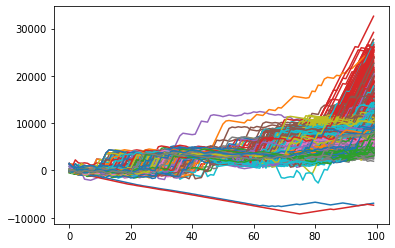

In [37]:
import matplotlib.colors as mcolors

# Assuming you already have vpn_features_cumul_np and vpn_labels_cumul_np defined

unique_labels = np.unique(labels)
num_labels = len(unique_labels)

# Create a label to integer mapping
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Create a colormap
cmap = plt.get_cmap("tab10", num_labels)


# Normalize the integer labels to the range of the colormap
norm = mcolors.Normalize(vmin=0, vmax=num_labels - 1)

for x in range(features_cumul.shape[0]):
    label_integer = label_mapping[labels[x]]
    color = cmap(norm(label_integer))
    plt.plot(features_cumul[x], color=color)

plt.show()

In [39]:

def vis_df_catorgy(label):
    cat = []

    for i, x in enumerate(features_df):
        if labels[i] == label:
            cat.append(x)

    # Convert the list to a NumPy array
    cat_np = np.array(cat)

    # Repeat each row along the y-axis by a factor of 100
    cat_scaled = np.repeat(cat_np, repeats=100, axis=0)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15, 15))

    # Display the scaled data
    im = ax.imshow(cat_scaled, cmap='viridis', interpolation='nearest')

    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax)

    plt.show()

In [40]:
def vis_df_mod_catorgy(label):
    cat = []

    for i, x in enumerate(features_df_mod):
        if labels[i] == label:
            cat.append(x)

    # Convert the list to a NumPy array
    cat_np = np.array(cat)

    # Repeat each row along the y-axis by a factor of 100
    cat_scaled = np.repeat(cat_np, repeats=100, axis=0)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15, 15))

    # Display the scaled data
    im = ax.imshow(cat_scaled, cmap='viridis', interpolation='nearest')

    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax)

    plt.show()

In [48]:
unique_elements, counts = np.unique(labels, return_counts=True)

# Zip the unique elements and their counts together
element_counts = zip(unique_elements, counts)

# Sort by counts in descending order and take the top 5
top_10_elements = sorted(element_counts, key=lambda x: x[1], reverse=True)[:10]

print(top_10_elements)

[('www.uwe.ac.uk', 320), ('www.youtube.com', 312), ('www.google.com', 310), ('www.wikipedia.com', 308), ('www.amazon.co.uk', 307), ('www.google.co.uk', 301), ('www.ebay.co.uk', 297), ('www.twitter.com', 290), ('www.facebook.com', 286), ('www.bbc.co.uk', 269)]


In [49]:
print([x[0] for x in top_10_elements])

['www.uwe.ac.uk', 'www.youtube.com', 'www.google.com', 'www.wikipedia.com', 'www.amazon.co.uk', 'www.google.co.uk', 'www.ebay.co.uk', 'www.twitter.com', 'www.facebook.com', 'www.bbc.co.uk']


In [42]:
features_df[0]

array([-1,  1, -1, ...,  0,  0,  0])

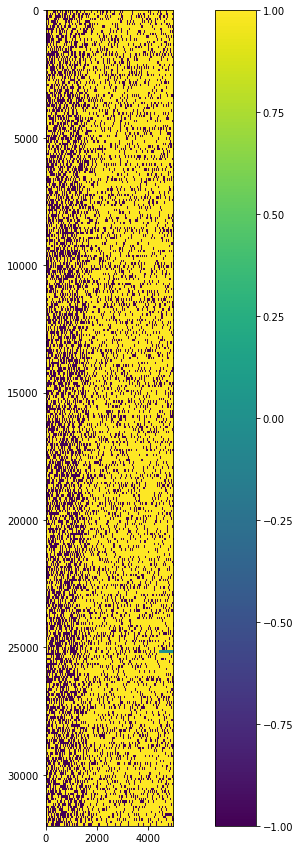

In [45]:
vis_df_catorgy("www.uwe.ac.uk")

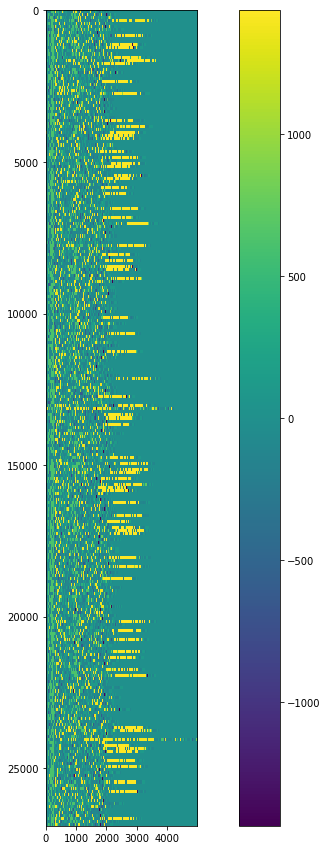

In [46]:
vis_df_mod_catorgy("www.bbc.co.uk")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


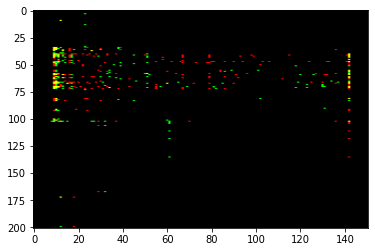

In [47]:
plt.imshow(np.pad(features_matrix[0], (0,1)), aspect="auto")